# Benchmarking affine transforms using numpy, cupy and clesperanto.
Here we compare performance of affine transforms implemented in [cupy](https://cupy.dev), [scipy](https://scipy.org) and clEsperanto.

If you run this notebook in Google colab, you need to install OpenCL. Uncomment these lines ([read why](https://github.com/clEsperanto/pyclesperanto_prototype/issues/300)) and after running them, restart the kernel.

In [1]:
# !sudo apt update
# !sudo apt purge *nvidia* -y
# !sudo DEBIAN_FRONTEND=noninteractive apt install nvidia-driver-530 -y

In [2]:
# !pip install pyclesperanto_prototype stackview ipycanvas==0.11

In [3]:
import pyclesperanto_prototype as cle
from skimage.io import imread, imshow
import numpy as np
import time
import cupy
from cupyx.scipy import ndimage as ndi
from scipy import ndimage as sndi

In [4]:
cle.available_device_names()

['NVIDIA GeForce RTX 3050 Ti Laptop GPU',
 'gfx1035',
 'cupy backend (experimental)']

In [5]:
# to measure kernel execution duration properly, we need to set this flag. It will slow down exection of workflows a bit though
cle.set_wait_for_kernel_finish(True)

# selet a GPU with the following in the name. This will fallback to any other GPU if none with this name is found
cle.select_device('RTX')

<NVIDIA GeForce RTX 3050 Ti Laptop GPU on Platform: NVIDIA CUDA (1 refs)>

In [6]:
image = imread('../../data/Haase_MRT_tfl3d1.tif')

# if you run this on Google colab, use this line instead:
# image = imread('https://github.com/clEsperanto/pyclesperanto_prototype/raw/master/data/Haase_MRT_tfl3d1.tif')

(120, 160, 160)

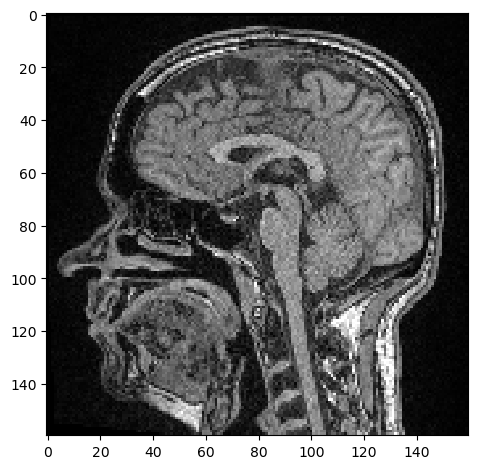

In [7]:
imshow(image[60])
image.shape

In [8]:
# scaling by factor 1 / s
s = 0.5
matrix = np.asarray([
    [s, 0, 0, 0],
    [0, s, 0, 0],
    [0, 0, s, 0],
    [0, 0, 0, 1],
])
output_shape = tuple((np.asarray(image.shape) / s).astype(int))
print(output_shape)

(240, 320, 320)


## cupy

cupy affine transform duration: 0.6152448654174805
cupy affine transform duration: 0.47624683380126953
cupy affine transform duration: 0.47826576232910156
cupy affine transform duration: 0.4772326946258545
cupy affine transform duration: 0.47624683380126953
cupy affine transform duration: 0.4783165454864502
cupy affine transform duration: 0.47821831703186035
cupy affine transform duration: 0.4762718677520752
cupy affine transform duration: 0.4765815734863281
cupy affine transform duration: 0.47722506523132324


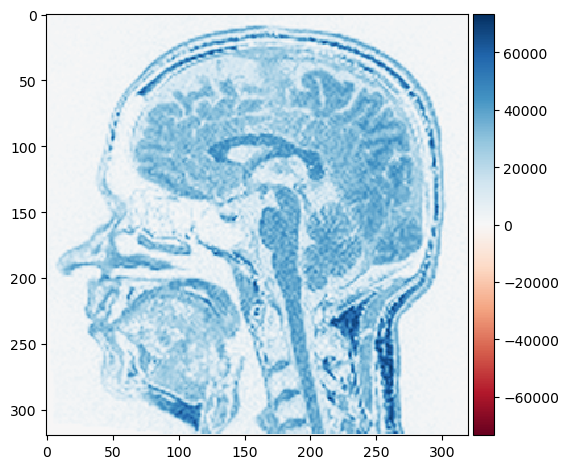

In [9]:
cuda_image = cupy.asarray(image)

cuda_scaled = cupy.ndarray(output_shape)
for i in range(0, 10):
    start_time = time.time()
    ndi.affine_transform(cuda_image, cupy.asarray(matrix), output=cuda_scaled, output_shape=output_shape)
    cupy.cuda.stream.get_current_stream().synchronize() # we need to wait here to measure time properly
    print("cupy affine transform duration: " + str(time.time() - start_time))
          
result = cupy.asnumpy(cuda_scaled)
imshow(result[120])

## clEsperanto

clEsperanto affine transform duration: 0.12644553184509277
clEsperanto affine transform duration: 0.007018327713012695
clEsperanto affine transform duration: 0.008021116256713867
clEsperanto affine transform duration: 0.008028507232666016
clEsperanto affine transform duration: 0.007000446319580078
clEsperanto affine transform duration: 0.007029533386230469
clEsperanto affine transform duration: 0.006360530853271484
clEsperanto affine transform duration: 0.006039142608642578
clEsperanto affine transform duration: 0.007018566131591797
clEsperanto affine transform duration: 0.006997823715209961


C:\Users\haase\mambaforge\envs\cupy39_1\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:149: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


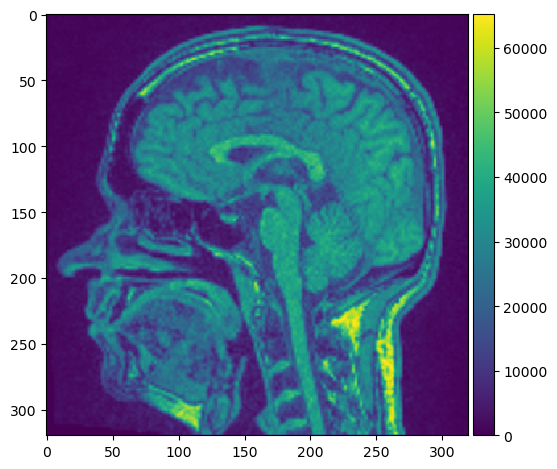

In [10]:
ocl_image = cle.push(image)

ocl_scaled = cle.create(output_shape)
for i in range(0, 10):
    start_time = time.time()
    cle.affine_transform(ocl_image, ocl_scaled, transform=np.linalg.inv(matrix), linear_interpolation=True)
    print("clEsperanto affine transform duration: " + str(time.time() - start_time))

result = cle.pull(ocl_scaled)
imshow(result[120])

## Scipy

scipy affine transform duration: 5.541515111923218
scipy affine transform duration: 5.8603339195251465
scipy affine transform duration: 5.429217576980591
scipy affine transform duration: 5.857398986816406
scipy affine transform duration: 5.533779859542847
scipy affine transform duration: 5.851352214813232
scipy affine transform duration: 5.804187297821045
scipy affine transform duration: 5.735005617141724
scipy affine transform duration: 5.749042749404907
scipy affine transform duration: 5.7119457721710205


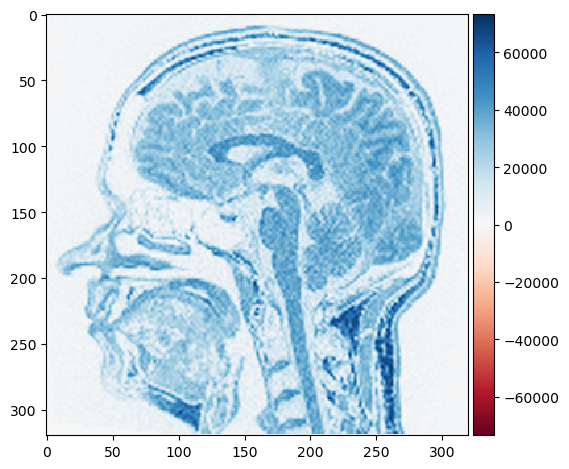

In [11]:
scaled = np.ndarray(output_shape)
for i in range(0, 10):
    start_time = time.time()
    sndi.affine_transform(image, matrix, output=scaled, output_shape=output_shape)
    print("scipy affine transform duration: " + str(time.time() - start_time))

imshow(scaled[120])

## Exercise
Run the benchmark using different scaling factors. Make the image much smaller and much larger. In which case does it make sense to use a GPU and in which not?

## Exercise
Benchmark another operation such as Gaussian blur, connected component labeling or axis transposition ([hint 1](https://github.com/clEsperanto/pyclesperanto_prototype/blob/master/benchmarks/gaussian_blur.ipynb), [hint 2](https://github.com/clEsperanto/pyclesperanto_prototype/blob/master/benchmarks/connected_component_labeling.ipynb), [hint 3](https://github.com/clEsperanto/pyclesperanto_prototype/blob/master/benchmarks/transpose.ipynb)).